# Deepfake detection using GAN


In [86]:
# Imports
import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import pandas as pd

import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns
import matplotlib


In [87]:
# Configure plots
matplotlib.style.use("seaborn-poster")  # Poster = big, paper = small
matplotlib.style.use("ggplot")
matplotlib.rcParams["font.family"] = "serif"
sns.set_context("poster")  # Poster = big, paper = small


In [88]:
# Paths
train_set = "train/real"
test_set = "test_set/"


In [89]:
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


In [90]:
transform = tv.transforms.Compose(
        [
            tv.transforms.Resize(64),
            tv.transforms.CenterCrop(64),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [91]:
# Load the dataset
dataset = tv.datasets.ImageFolder(
    root=train_set,
    transform=transform,
)

# Use dataloader to get batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [92]:
# Custom weights initialization
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


In [93]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [94]:
# Create the generator
net_gen = Generator()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
net_gen.apply(init_weights);


In [95]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


In [96]:
# Create the Discriminator
net_disc = Discriminator()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
net_disc.apply(init_weights);


In [97]:

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Loss function
loss_fn = torch.nn.BCELoss()

# Optiomisers
net_disc.optimiser = torch.optim.Adam(net_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
net_gen.optimiser = torch.optim.Adam(net_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [98]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in tqdm(enumerate(dataloader, 0)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        net_disc.zero_grad()
        # Format batch
        real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = net_disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1)
        # Generate fake image batch with G
        fake = net_gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = net_disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        net_disc.optimiser.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = net_disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        net_gen.optimiser.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = net_gen(fixed_noise).detach().cpu()
            img_list.append(tv.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...


  0%|          | 0/10 [00:00<?, ?it/s]

[0/10][0/229]	Loss_D: 1.6390	Loss_G: 4.2711	D(x): 0.4255	D(G(z)): 0.4260 / 0.0167


[0/10][50/229]	Loss_D: 0.0289	Loss_G: 8.2189	D(x): 0.9749	D(G(z)): 0.0006 / 0.0005


[0/10][100/229]	Loss_D: 0.0008	Loss_G: 35.4923	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


[0/10][150/229]	Loss_D: 1.8376	Loss_G: 37.0303	D(x): 0.9441	D(G(z)): 0.7263 / 0.0000


[0/10][200/229]	Loss_D: 0.4309	Loss_G: 5.9439	D(x): 0.9353	D(G(z)): 0.2158 / 0.0057


229it [14:59,  3.93s/it]
 10%|█         | 1/10 [14:59<2:14:58, 899.89s/it]

[1/10][0/229]	Loss_D: 0.7869	Loss_G: 2.6412	D(x): 0.5664	D(G(z)): 0.0244 / 0.1623


[1/10][50/229]	Loss_D: 0.2621	Loss_G: 4.3928	D(x): 0.8735	D(G(z)): 0.0902 / 0.0241


[1/10][100/229]	Loss_D: 0.2891	Loss_G: 4.0178	D(x): 0.8783	D(G(z)): 0.1061 / 0.0311


[1/10][150/229]	Loss_D: 0.2777	Loss_G: 4.3536	D(x): 0.8433	D(G(z)): 0.0465 / 0.0428


[1/10][200/229]	Loss_D: 0.2527	Loss_G: 4.3054	D(x): 0.8453	D(G(z)): 0.0433 / 0.0257


229it [09:50,  2.58s/it]
 20%|██        | 2/10 [24:50<1:35:44, 718.10s/it]

[2/10][0/229]	Loss_D: 0.6542	Loss_G: 8.1445	D(x): 0.9619	D(G(z)): 0.4016 / 0.0024


[2/10][50/229]	Loss_D: 0.2474	Loss_G: 3.8288	D(x): 0.8816	D(G(z)): 0.0661 / 0.0376


[2/10][100/229]	Loss_D: 0.1763	Loss_G: 4.2428	D(x): 0.8774	D(G(z)): 0.0282 / 0.0419


[2/10][150/229]	Loss_D: 0.2983	Loss_G: 4.7417	D(x): 0.9314	D(G(z)): 0.1639 / 0.0171


[2/10][200/229]	Loss_D: 0.1000	Loss_G: 5.0206	D(x): 0.9740	D(G(z)): 0.0668 / 0.0099


229it [09:52,  2.59s/it]
 30%|███       | 3/10 [34:43<1:17:05, 660.74s/it]

[3/10][0/229]	Loss_D: 0.1364	Loss_G: 3.9705	D(x): 0.9689	D(G(z)): 0.0946 / 0.0279


[3/10][50/229]	Loss_D: 0.7644	Loss_G: 7.3921	D(x): 0.8909	D(G(z)): 0.3620 / 0.0239


[3/10][100/229]	Loss_D: 0.1419	Loss_G: 3.9480	D(x): 0.9182	D(G(z)): 0.0486 / 0.0314


[3/10][150/229]	Loss_D: 0.1130	Loss_G: 4.0276	D(x): 0.9838	D(G(z)): 0.0871 / 0.0271


[3/10][200/229]	Loss_D: 0.2454	Loss_G: 4.5751	D(x): 0.9694	D(G(z)): 0.1740 / 0.0172


229it [10:08,  2.66s/it]
 40%|████      | 4/10 [44:51<1:04:00, 640.16s/it]

[4/10][0/229]	Loss_D: 0.2176	Loss_G: 3.7925	D(x): 0.9229	D(G(z)): 0.1176 / 0.0334


[4/10][50/229]	Loss_D: 0.1136	Loss_G: 3.7237	D(x): 0.9567	D(G(z)): 0.0607 / 0.0371


[4/10][100/229]	Loss_D: 0.1197	Loss_G: 4.1717	D(x): 0.9797	D(G(z)): 0.0889 / 0.0236


[4/10][150/229]	Loss_D: 0.2383	Loss_G: 3.0919	D(x): 0.8264	D(G(z)): 0.0270 / 0.0737


[4/10][200/229]	Loss_D: 0.0894	Loss_G: 4.3481	D(x): 0.9467	D(G(z)): 0.0315 / 0.0178


229it [10:42,  2.80s/it]
 50%|█████     | 5/10 [55:33<53:24, 640.86s/it]  

[5/10][0/229]	Loss_D: 0.1436	Loss_G: 4.4582	D(x): 0.9739	D(G(z)): 0.0929 / 0.0227


[5/10][50/229]	Loss_D: 0.1397	Loss_G: 3.7453	D(x): 0.9518	D(G(z)): 0.0750 / 0.0410


[5/10][100/229]	Loss_D: 0.2726	Loss_G: 3.2710	D(x): 0.8696	D(G(z)): 0.1020 / 0.0658


[5/10][150/229]	Loss_D: 0.1230	Loss_G: 3.7624	D(x): 0.9327	D(G(z)): 0.0475 / 0.0383


[5/10][200/229]	Loss_D: 0.1296	Loss_G: 3.6997	D(x): 0.9871	D(G(z)): 0.1032 / 0.0357


229it [09:01,  2.36s/it]
 60%|██████    | 6/10 [1:04:35<40:28, 607.08s/it]

[6/10][0/229]	Loss_D: 0.0861	Loss_G: 4.6558	D(x): 0.9361	D(G(z)): 0.0148 / 0.0154


[6/10][50/229]	Loss_D: 0.4376	Loss_G: 2.9479	D(x): 0.7687	D(G(z)): 0.0418 / 0.1326


[6/10][100/229]	Loss_D: 0.6402	Loss_G: 1.9297	D(x): 0.6323	D(G(z)): 0.0945 / 0.2057


[6/10][150/229]	Loss_D: 0.1910	Loss_G: 3.5953	D(x): 0.8939	D(G(z)): 0.0541 / 0.0463


[6/10][200/229]	Loss_D: 0.2059	Loss_G: 2.7575	D(x): 0.8604	D(G(z)): 0.0427 / 0.1001


229it [08:45,  2.29s/it]
 70%|███████   | 7/10 [1:13:20<29:01, 580.39s/it]

[7/10][0/229]	Loss_D: 0.0827	Loss_G: 3.6846	D(x): 0.9794	D(G(z)): 0.0581 / 0.0389


[7/10][50/229]	Loss_D: 0.0775	Loss_G: 4.1483	D(x): 0.9574	D(G(z)): 0.0309 / 0.0247


[7/10][100/229]	Loss_D: 0.0897	Loss_G: 3.7538	D(x): 0.9530	D(G(z)): 0.0357 / 0.0355


[7/10][150/229]	Loss_D: 0.1179	Loss_G: 3.9662	D(x): 0.9468	D(G(z)): 0.0556 / 0.0314


[7/10][200/229]	Loss_D: 0.4627	Loss_G: 4.5951	D(x): 0.8888	D(G(z)): 0.2154 / 0.0284


229it [08:37,  2.26s/it]
 80%|████████  | 8/10 [1:21:58<18:40, 560.38s/it]

[8/10][0/229]	Loss_D: 0.2684	Loss_G: 3.5620	D(x): 0.8891	D(G(z)): 0.1195 / 0.0495


[8/10][50/229]	Loss_D: 0.1021	Loss_G: 3.9818	D(x): 0.9701	D(G(z)): 0.0649 / 0.0319


[8/10][100/229]	Loss_D: 0.1401	Loss_G: 3.3223	D(x): 0.9455	D(G(z)): 0.0762 / 0.0575


[8/10][150/229]	Loss_D: 0.0513	Loss_G: 5.5027	D(x): 0.9633	D(G(z)): 0.0125 / 0.0097


[8/10][200/229]	Loss_D: 0.0802	Loss_G: 4.2933	D(x): 0.9446	D(G(z)): 0.0200 / 0.0244


229it [08:22,  2.19s/it]
 90%|█████████ | 9/10 [1:30:20<09:02, 542.31s/it]

[9/10][0/229]	Loss_D: 0.1692	Loss_G: 4.7210	D(x): 0.9930	D(G(z)): 0.1353 / 0.0145


[9/10][50/229]	Loss_D: 0.1441	Loss_G: 4.7444	D(x): 0.9868	D(G(z)): 0.1088 / 0.0156


[9/10][100/229]	Loss_D: 0.2496	Loss_G: 7.4818	D(x): 0.9961	D(G(z)): 0.1874 / 0.0009


[9/10][150/229]	Loss_D: 0.1882	Loss_G: 4.0809	D(x): 0.9706	D(G(z)): 0.1374 / 0.0267


[9/10][200/229]	Loss_D: 0.1962	Loss_G: 4.0992	D(x): 0.9526	D(G(z)): 0.1279 / 0.0298


229it [07:46,  2.04s/it]
100%|██████████| 10/10 [1:38:07<00:00, 588.76s/it]


<AxesSubplot:>

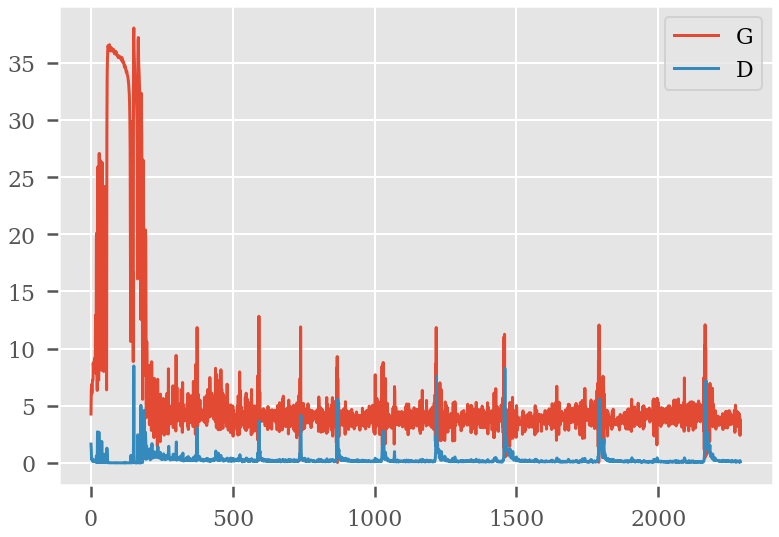

In [99]:
sns.lineplot(x=range(len(G_losses)), y=G_losses, label="G")
sns.lineplot(x=range(len(D_losses)), y=D_losses, label="D")


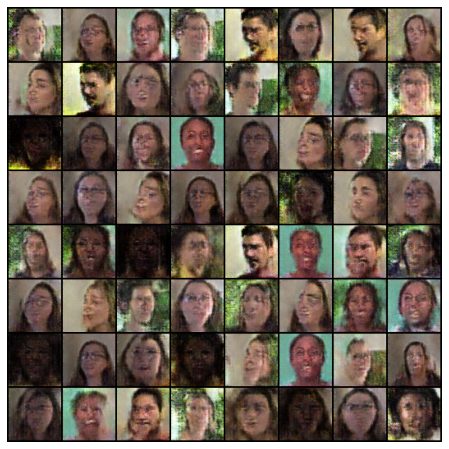

In [100]:

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


In [101]:
net_disc.eval();


In [102]:
def predict_folder(path):
    total = {}
    videos = tv.datasets.ImageFolder(
        root=path,
        transform=transform,
    )

    for ind, val in tqdm(videos.class_to_idx.items()):
        low = math.inf
        high = -1
        for i, ele in enumerate(videos.imgs):
            _, idx = ele
            if idx == val:
                if i < low:
                    low = i
                if i > high:
                    high = i
        high += 1
        video = torch.utils.data.Subset(videos, range(low, high))
        results = {}
        frame_names = videos.imgs[low:high]
        frame_names = [name[0] for name in frame_names]
        name_iter = iter(frame_names)
        with torch.no_grad():
            for i, frame in enumerate(video):
                frame_name = next(name_iter)
                frame = frame[0]
                frame = frame.view(1, *frame.shape)
                pred = net_disc(frame).item()
                if (
                    i != 0 and not "face0" in frame_name
                ):  # If the face is part of a frame with multiple faces, always select the one most likely to be fake.
                    frame_name = list(results.keys())[-1]
                    results[frame_name] = (
                        pred if pred < results[frame_name] else results[frame_name]
                    )
                else:
                    results[frame_name] = pred
        values = list(results.values())
        total[ind] = round(
            np.mean(values)
        )  # Classify the video as fake or real based on the majority of the frames.
    return total


In [109]:
total_real = predict_folder(test_set + "real")


100%|██████████| 14/14 [00:56<00:00,  4.05s/it]


In [110]:
df_real = pd.DataFrame(total_real.values(), total_real.keys())

print(f"Correctly classified videos: {df_real[0].sum()}")
print(f"Incorrectly classified videos: {len(df_real.index) - df_real[0].sum()}")
print(
    f"Percantage corretly classified: {round((df_real[0].sum() / len(df_real.index)) * 100, 2)}%"
)


Correctly classified videos: 0
Incorrectly classified videos: 14
Percantage corretly classified: 0.0%


In [111]:
total_fake = predict_folder(train_set)


100%|██████████| 61/61 [02:23<00:00,  2.35s/it]


In [112]:
df_fake = pd.DataFrame(total_fake.values(), total_fake.keys())

print(f"Correctly classified videos: {len(df_fake) - df_fake[0].sum()}")
print(f"Incorrectly classified videos: {df_fake[0].sum()}")
print(
    f"Percantage corretly classified: {round(((len(df_fake) - df_fake[0].sum()) / len(df_fake)) * 100, 2)}%"
)


Correctly classified videos: 7
Incorrectly classified videos: 54
Percantage corretly classified: 11.48%
